In [1]:
import pandas as pd
import numpy as np
from data import train, test
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import scipy
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
vle = pd.merge(train.studentVle, train.vle, 
         on=['code_module', 'code_presentation', 'id_site'], 
         how='left')

ft = train.assessments.groupby(
    ['code_module', 'code_presentation'])['date'].agg('min').reset_index()

reg = pd.merge(train.studentInfo, train.studentRegistration, 
         on=['code_module', 'code_presentation', 'id_student'])

In [5]:
features = [
    'code_module', 'code_presentation', 'id_student',
    'date_unregistration', 'final_result']


In [6]:
df = vle.merge(ft, on=['code_module', 'code_presentation'], how='left')
df = df.merge(reg, on=['code_module', 'code_presentation', 'id_student'], how='left')
features = ['code_module', 'code_presentation', 'id_student', 
            'date_x', 'date_y', 'sum_click', 'activity_type',
           'final_result', 'date_unregistration']
df = df[features]
df.columns = ['code_module', 'code_presentation', 'id_student', 
              'date', 'date_assessment', 'sum_click', 'activity_type',
             'final_result', 'date_unregistration']
df['final_result'] = df['final_result'].map({'Pass': 0, 'Distinction': 0, 
                                             'Fail': 1, 'Withdrawn': 2})

In [7]:
bft = df.query('date <= date_assessment and not date_unregistration <= 7')

In [8]:
bft = bft.groupby(
        ['code_module', 'code_presentation', 
         'id_student', 'date', 'activity_type']
        )['date_assessment', 'sum_click'].agg(
        {'date_assessment': 'mean', 
         'sum_click':'sum',
        'final_result': 'mean'}).reset_index()

/Users/banchisme/anaconda2/envs/nlp/lib/python2.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [9]:
def get_joint_distribution(df, code_module, code_presentation, id_student, 
                     relative_to_course_start=True, ignore_neg_date=True):
    r'''This function gets the joint distribution of activity and dates for 
        a student * module * presentation
    
        Arguments:
            df (pandas.DataFrame): data frame that holds all student vle 
                interaction before the first test
            code_module (string): identifier for a module
            code_presentation (string): identifier for a presentation
            id_student (int): identifier for a student
            relative_to_course_start (bool, optional): if True, date is relative 
                to course start, otherwise, relative to first assessment. 
                Default: ``True``
            ignore_neg_data (bool, optional): if True, student vle activites prior
                to course start date is ignored. Default: ``True``
        
        Returns:
            pandas.DataFrame:
                data frame that records the distribution of students' vle click sum 
                across activity and dates
        
        Example::
            >>> get_distribution(df, 'AAA', '2013J', 1303)
                forum    homepage
            0   0        0
            1   0.5      0.5
        '''
    
    sql = "code_module == '{}' and code_presentation == '{}' and id_student == {}".format(
        code_module, code_presentation, id_student)
    if ignore_neg_date:
        sql = sql + ' and date >= 0'    
    sub = df.query(sql)
    
    # handle corner case where sub is empty
    if len(sub) == 0:
        return pd.DataFrame()
    
    start_date = min(0, sub['date'].min())
    end_date = int(sub['date_assessment'].mean())
    dates = range(start_date, end_date + 1)
    
    activities = df['activity_type'].unique()
    
    # reset index for faster access
    sub = sub.set_index(['date', 'activity_type'])
    sub['sum_click'] = sub['sum_click'] / sub['sum_click'].sum()
    
    res = defaultdict(lambda: [])
    for date in dates:
        for activity in activities:
            try:
                val = sub.at[(date, activity), 'sum_click']
            except KeyError:
                val = 0
            finally:
                res[activity].append(val)
                
    # format res as a pandas dataframe
    return pd.DataFrame(res, index=dates)

In [10]:
def marginalize(joint_dist, axis=0):
    r'''this function marginalize a joint distribution long an axis
    
        Arguments:
            joint_dist (pandas.DataFrame): a joint distribution of a students'
                vle clicks across activity types and dates
            axis (int, optional): the axis to marginalize the distribution.
                0 if marginalize along activity types, 1 if marginalize along dates.
                Default: ``0``
        Returns:
            pandas.Series:
                series that records a student's marginalized click distribution
        
        Example::
            >>>marginalize(joint)
            0 0.1
            1 0.9
    '''
    return joint_dist.sum(axis=axis)
    

In [11]:
def flatten(joint):
    r'''this function flatten a joint distribution to a vector
    
        Arguments:
            joint (pandas.DataFrame): a joint distribution of a student's
            vle clicks across activity types and dates
        Returns:
            numpy.array:
                1-D vector that represents the joint distribution
        Example::
            >>flatten(pd.DataFrame([[0.1, 0.2], [0.5, 0.2]]))
            array([0.1, 0.2, 0.5, 0.2])
    '''
    
    return joint.values.reshape(-1)

In [12]:
joint = get_joint_distribution(bft, 'AAA', '2013J', 147793)

In [13]:
marg = marginalize(joint)

In [14]:
scipy.stats.entropy(flatten(joint), base=2)

0.0

### Calculate time entropy for a sample course

In [15]:
sample_course = ('AAA', '2013J')
module, presentation = sample_course
sample_bft = bft.query("code_module == '{}' and code_presentation == '{}'"
                      .format(module, presentation)).copy()
students = sample_bft['id_student'].unique()

In [16]:
joints = []
entropy_joint = []
entropy_date = []
entropy_acty = []
results = []

for s in tqdm_notebook(students):
    try:
        joint = get_joint_distribution(bft, module, presentation, s)
        marg_acty = marginalize(joint, axis=0)
        marg_date = marginalize(joint, axis=1)
        joints.append(joint)
        entropy_joint.append(scipy.stats.entropy(flatten(joint), base=2))
        entropy_date.append(scipy.stats.entropy(marg_date, base=2))
        entropy_acty.append(scipy.stats.entropy(marg_acty, base=2))
        results.append(sample_bft[sample_bft['id_student'] == s]['final_result'].mean())
    except:
        print(s)
        
summary = pd.DataFrame({'joints': joints, 
                        'entropy_joint': entropy_joint,
                        'entropy_date': entropy_date, 
                        'entropy_acty': entropy_acty,
                       'result': results},
                      index=students)

/Users/banchisme/anaconda2/envs/nlp/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


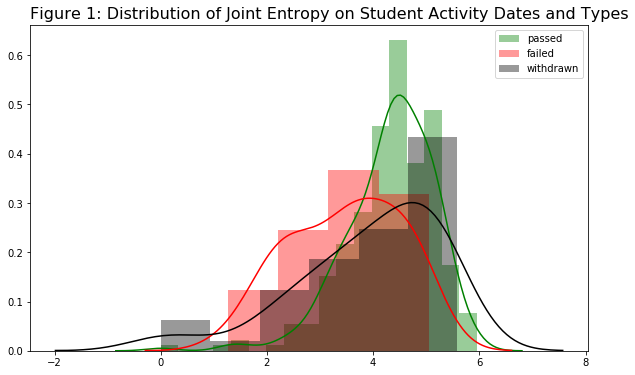

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(summary[summary['result']==0]['entropy_joint'], ax=ax, 
             color='g', label='passed')
sns.distplot(summary[summary['result']==1]['entropy_joint'], ax=ax, 
             color='r', label='failed')
sns.distplot(summary[summary['result']==2]['entropy_joint'], ax=ax, 
             color='k', label='withdrawn')
ax.set_xlabel('')
ax.legend()
_ = ax.set_title('Figure 1: Distribution of Joint Entropy on Student Activity Dates and Types',
                {'fontsize':16}, loc='left')

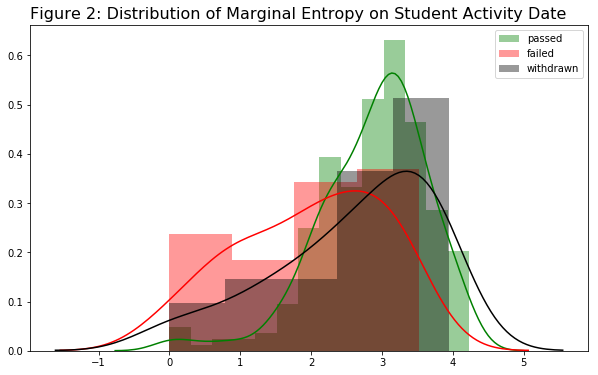

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(summary[summary['result']==0]['entropy_date'], ax=ax, 
             color='g', label='passed')
sns.distplot(summary[summary['result']==1]['entropy_date'], ax=ax, 
             color='r', label='failed')
sns.distplot(summary[summary['result']==2]['entropy_date'], ax=ax, 
             color='k', label='withdrawn')
ax.set_xlabel('')
ax.legend()
_ = ax.set_title('Figure 2: Distribution of Marginal Entropy on Student Activity Date',
                {'fontsize':16}, loc='left')

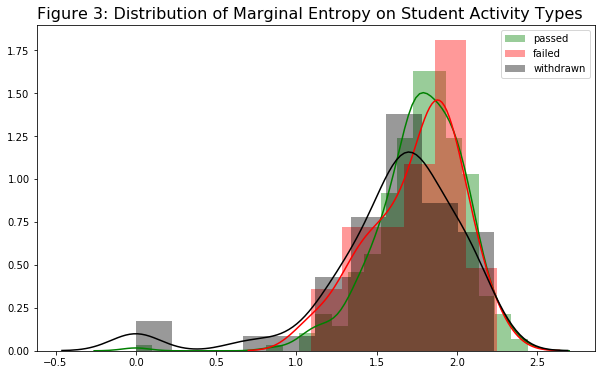

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.distplot(summary[summary['result']==0]['entropy_acty'], ax=ax, 
             color='g', label='passed')
sns.distplot(summary[summary['result']==1]['entropy_acty'], ax=ax, 
             color='r', label='failed')
sns.distplot(summary[summary['result']==2]['entropy_acty'], ax=ax, 
             color='k', label='withdrawn')
ax.set_xlabel('')
ax.legend()
_ = ax.set_title('Figure 3: Distribution of Marginal Entropy on Student Activity Types',
                {'fontsize':16}, loc='left')

In [21]:
summary['entropy_joint'].quantile(np.linspace(0, 1, 10))

0.000000    0.000000
0.111111    3.014954
0.222222    3.575456
0.333333    3.949049
0.444444    4.243774
0.555556    4.459999
0.666667    4.692791
0.777778    4.986264
0.888889    5.158907
1.000000    5.957742
Name: entropy_joint, dtype: float64

In [37]:
low_date = summary[summary['entropy_date'] < summary['entropy_date'].quantile(.33)]

In [39]:
low_date.head()

,entropy_acty,entropy_date,entropy_joint,joints,result
11391,1.549172,2.215809,3.289843,dataplus dualpane externalquiz forumng...,0.0
30268,1.766972,2.431884,3.674706,dataplus dualpane externalquiz forumng...,2.0
45462,1.638535,2.181029,3.665382,dataplus dualpane externalquiz forumng...,0.0
62155,1.543438,2.310593,3.546227,dataplus dualpane externalquiz forumng...,0.0
65002,1.389482,2.068915,3.304562,dataplus dualpane externalquiz forumng...,2.0


In [51]:
summary.sort_values('entropy_date').tail()

,entropy_acty,entropy_date,entropy_joint,joints,result
1626710,1.404156,4.125596,5.275824,dataplus dualpane externalquiz forumng...,0.0
312537,1.618433,4.188893,5.651886,dataplus dualpane externalquiz forumng...,0.0
2641155,2.010112,4.192308,5.957742,dataplus dualpane externalquiz forumng...,0.0
174782,1.757331,4.224609,5.714442,dataplus dualpane externalquiz forumng...,0.0
2364471,1.594700,4.229858,5.518764,dataplus dualpane externalquiz forumng...,0.0


In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
label_encoder = LabelEncoder()

In [26]:
label_encoder.fit(sample_bft['activity_type'].unique())

LabelEncoder()

In [27]:
sample_bft['activity_label'] = label_encoder.transform(sample_bft['activity_type'])

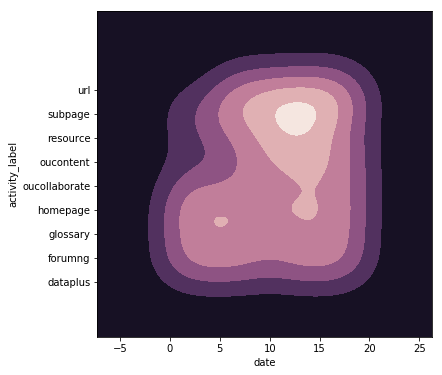

In [52]:
d = sample_bft.loc[(sample_bft.date >= 0 ) & (sample_bft.id_student==2364471), :]
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
g = sns.kdeplot(d.date, d.activity_label, cmap=cmap, n_levels=5, shade=True)
g.set_yticks(range(len(label_encoder.classes_)))
_ = g.set_yticklabels(label_encoder.classes_)

In [210]:
avg_lost =  

3    5380
5    4260
7    3423
1    3142
8    1752
6     981
4     141
0      76
2      61
Name: activity_label, dtype: int64